# Graph reconstruction in 3d 

In 3d there is no implemented filtered Back projection, hence we accomodate it 
by structuring the ECT to make the FBP easier. 
 


In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.transforms.functional as f

np.random.seed(42)

NUM_STEPS=256
NUM_PTS = 10

def generate_thetas():
    v = []
    for theta in torch.linspace(0,torch.pi,8):
        for phi in torch.linspace(0,torch.pi,64):
            v.append(
                torch.tensor([
                    torch.sin(phi)*torch.cos(theta),
                    torch.sin(phi)*torch.sin(theta),
                    torch.cos(phi)
                ])
                )
    return torch.vstack(v).T

v = generate_thetas()

In [2]:
scale = 200
def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
    ecc =  torch.nn.functional.sigmoid(scale * torch.sub(lin, nh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, nh)))
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(scale * torch.sub(lin, eh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, eh)))
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc



In [3]:
from torch_geometric.datasets import TUDataset
from datasets.transforms import CenterTransform
dataset = TUDataset(root="./data",name="alchemy_full",use_node_attr=True)

data = dataset[5]
data.x = data.x[:,:3]

ct = CenterTransform()
data = ct(data)

ei = data.edge_index
x = data.x


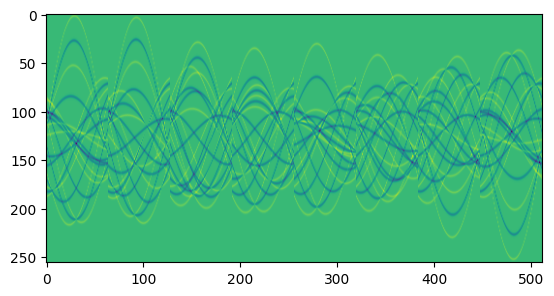

In [4]:

ect = compute_ect(data.x,v,ei=data.edge_index)

ect.shape
plt.imshow(ect)

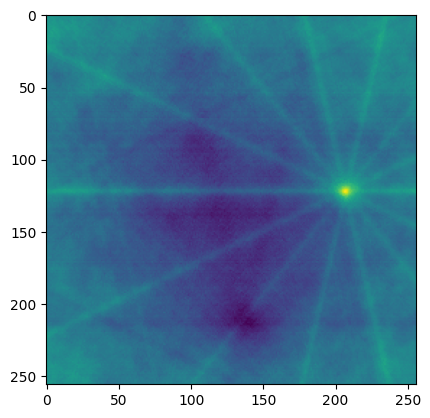

In [5]:
# ####################################################
# ### Reconstruct 3d using filtered backprojection.
# ####################################################

xg, yg ,zg = np.meshgrid(np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False), indexing='ij', sparse=True)

recon = torch.zeros(NUM_STEPS,NUM_STEPS,NUM_STEPS)

def calc_idx(theta,xg,yg,zg):
    heights = theta[0]*xg + theta[1]*yg + theta[2]*zg
    idx=((heights + 1)  * NUM_STEPS/2).long()+1
    idx[idx>NUM_STEPS-1]=NUM_STEPS-1
    return idx

i = 0
for theta,slice in zip(v.T,ect.T):
    i +=1    
    idx = calc_idx(theta,xg,yg,zg)
    reps = slice[idx]
    recon += reps


plt.imshow(recon[:,:,int(NUM_STEPS/2)])

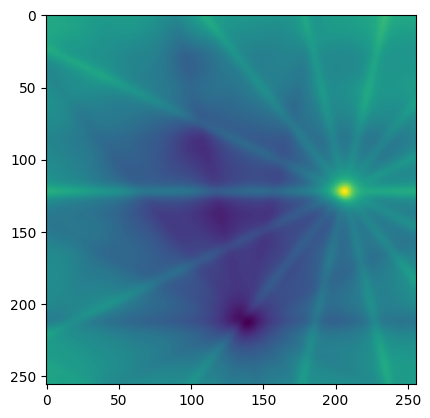

In [6]:
from scipy.ndimage import gaussian_filter

recon_f = gaussian_filter(recon,sigma=2)

plt.imshow(recon_f[:,:,128])

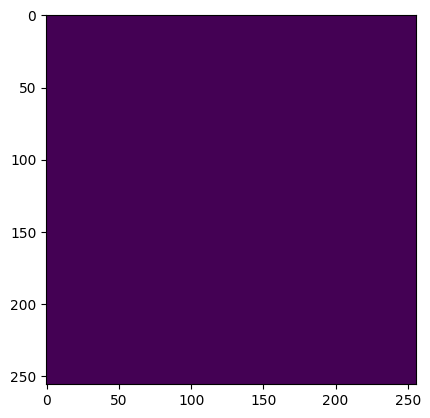

In [7]:
from scipy.ndimage import maximum_filter,minimum_filter
recon_np = recon.numpy()
res = maximum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
plt.imshow(mask[:,:,100])

In [8]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]

vals /=vals.max()

idx = np.where(vals>.5)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(pts)
print(data.x)



sorted(vals)

tensor([[-0.9688, -0.2031, -0.1250],
        [-0.5703, -0.2109, -0.1094],
        [-0.0625, -0.2266, -0.1016],
        [-0.0625,  0.3906,  0.4766],
        [-0.0469,  0.6094, -0.0234],
        [ 0.0859, -0.6953, -0.3047],
        [ 0.1406, -0.1094,  0.3906],
        [ 0.1719,  0.2109, -0.3203],
        [ 0.6484, -0.0391,  0.2734],
        [ 0.6641,  0.1562, -0.1484]], dtype=torch.float64)
tensor([[ 0.0868, -0.6885, -0.3055],
        [-0.0610, -0.2171, -0.0999],
        [-0.5709, -0.1973, -0.1116],
        [-0.9733, -0.1921, -0.1255],
        [ 0.1410, -0.0973,  0.3934],
        [-0.0647,  0.4001,  0.4749],
        [-0.0447,  0.6224, -0.0202],
        [ 0.1700,  0.2245, -0.3237],
        [ 0.6670,  0.1677, -0.1528],
        [ 0.6498, -0.0225,  0.2710]])


[tensor(-0.4989),
 tensor(-0.4974),
 tensor(-0.4877),
 tensor(-0.4754),
 tensor(-0.4672),
 tensor(-0.4657),
 tensor(-0.4627),
 tensor(-0.4589),
 tensor(-0.4534),
 tensor(-0.4477),
 tensor(-0.4394),
 tensor(-0.4371),
 tensor(-0.4318),
 tensor(-0.4304),
 tensor(-0.4289),
 tensor(-0.4247),
 tensor(-0.4234),
 tensor(-0.4219),
 tensor(-0.4195),
 tensor(-0.4194),
 tensor(-0.4178),
 tensor(-0.4175),
 tensor(-0.4008),
 tensor(-0.3976),
 tensor(-0.3946),
 tensor(-0.3861),
 tensor(-0.3815),
 tensor(-0.3802),
 tensor(-0.3777),
 tensor(-0.3773),
 tensor(-0.3761),
 tensor(-0.3715),
 tensor(-0.3669),
 tensor(-0.3665),
 tensor(-0.3624),
 tensor(-0.3617),
 tensor(-0.3553),
 tensor(-0.3543),
 tensor(-0.3525),
 tensor(-0.3504),
 tensor(-0.3500),
 tensor(-0.3497),
 tensor(-0.3488),
 tensor(-0.3448),
 tensor(-0.3445),
 tensor(-0.3424),
 tensor(-0.3413),
 tensor(-0.3395),
 tensor(-0.3395),
 tensor(-0.3341),
 tensor(-0.3303),
 tensor(-0.3293),
 tensor(-0.3289),
 tensor(-0.3259),
 tensor(-0.3256),
 tensor(-0

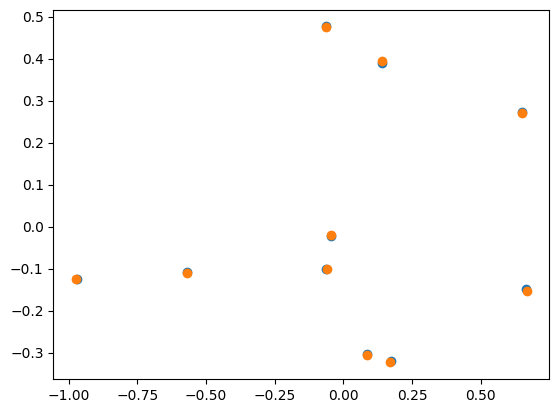

In [9]:
plt.scatter(pts[:,0],pts[:,2])
plt.scatter(data.x[:,0],data.x[:,2])




In [10]:
# x = x[x.norm(dim=1).argsort()]
# x


In [11]:
# pts = pts[pts.norm(dim=1).argsort()]
# pts

# Reconstruct Edges

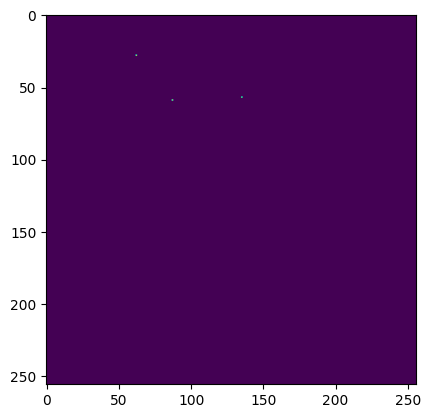

In [12]:
res = minimum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
plt.imshow(mask[:,:,128])

In [13]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]
vals /=vals.min()
idx = np.where(vals>.8)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


edge_pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(vals.sort()[0])


tensor([0.0416, 0.0420, 0.0421,  ..., 0.9468, 0.9643, 1.0000])


In [14]:
ei_true = []
for ei_idx in ei.T:
    # print(ei_idx)
    ei_true.append((x[ei_idx[0]]+x[ei_idx[1]])/2)

ei_true = torch.vstack(ei_true)
print(ei_true)
print(edge_pts)

tensor([[ 0.0129, -0.4528, -0.2027],
        [ 0.0129, -0.4528, -0.2027],
        [-0.3160, -0.2072, -0.1057],
        [ 0.0400, -0.1572,  0.1467],
        [ 0.0545,  0.0037, -0.2118],
        [-0.3160, -0.2072, -0.1057],
        [-0.7721, -0.1947, -0.1185],
        [-0.7721, -0.1947, -0.1185],
        [ 0.0400, -0.1572,  0.1467],
        [ 0.0382,  0.1514,  0.4341],
        [ 0.3954, -0.0599,  0.3322],
        [ 0.0382,  0.1514,  0.4341],
        [-0.0547,  0.5113,  0.2273],
        [-0.0547,  0.5113,  0.2273],
        [ 0.0627,  0.4235, -0.1720],
        [ 0.0545,  0.0037, -0.2118],
        [ 0.0627,  0.4235, -0.1720],
        [ 0.4185,  0.1961, -0.2383],
        [ 0.4185,  0.1961, -0.2383],
        [ 0.6584,  0.0726,  0.0591],
        [ 0.3954, -0.0599,  0.3322],
        [ 0.6584,  0.0726,  0.0591]])
tensor([[-0.7656, -0.2031, -0.1172],
        [-0.3125, -0.2188, -0.1016],
        [-0.0547,  0.5000,  0.2266],
        [ 0.0156, -0.4609, -0.2031],
        [ 0.0391, -0.1719,  0.1484],


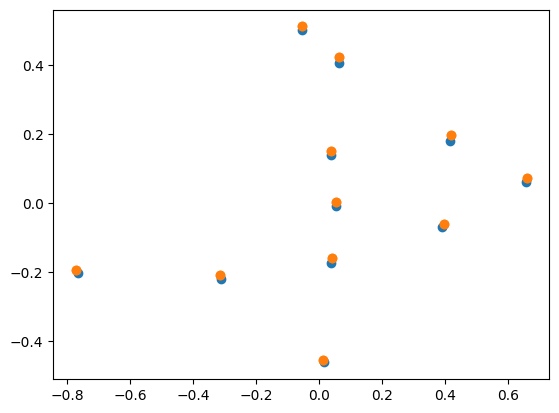

In [15]:
# plt.scatter(pts[:,0],pts[:,1])
plt.scatter(edge_pts[:,0],edge_pts[:,1])
plt.scatter(ei_true[:,0],ei_true[:,1])

In [16]:
print(ei.shape)
print(edge_pts.shape)

torch.Size([2, 22])
torch.Size([11, 3])


In [26]:
adj = np.zeros((len(pts),len(pts)))
ei_recon = []
for i in range(len(pts)):
    for j in range(len(pts)):
        pt_i = pts[i].reshape(1,3)
        pt_j = pts[j].reshape(1,3)
        pt = (pt_i+pt_j )/2
        
        for epts in edge_pts:
            if torch.norm(epts-pt) < .05:
                ei_recon.append([i,j])
        
        # pt.repeat(edge_pts.shape[0],axis=0)-edge_pts
        # print(np.linalg.norm(pt.repeat(edge_pts.shape[0],dim=0)-edge_pts,axis=1).min())
        # if np.linalg.norm(pt.repeat(edge_pts.shape[0],axis=0)-edge_pts,axis=1).min() < .1:
            # print("true")
# print(torch.tensor(ei_recon).shape)
# print(torch.tensor(ei_recon))

ei_recon = list(set([tuple(sorted(l)) for l in ei_recon]))
print(len(ei_recon))


11


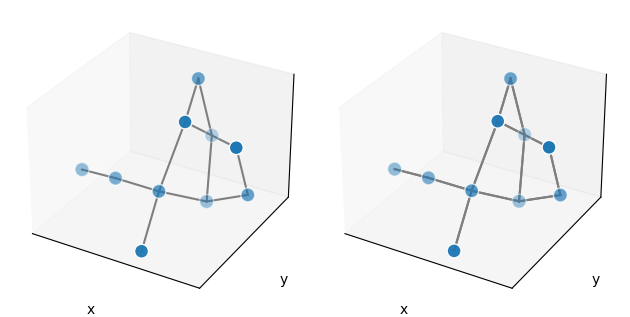

In [27]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
# G = nx.cycle_graph(20)
# pos = nx.spring_layout(G, dim=3, seed=779)

# 3d spring layout
# Extract node and edge positions from the layout
node_xyz = pts.numpy()

edge_xyz = np.array([(pts[u].numpy(), pts[v].numpy()) for u, v in ei_recon])


# node_xyz = pts
# edge_xyz = np.array(ei_recon).T

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()

########################################################################
###
########################################################################

ax = fig.add_subplot(122, projection="3d")

node_xyz = data.x.numpy()

edge_xyz = np.array([(node_xyz[u], node_xyz[v]) for u, v in data.edge_index.T])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()


plt.show()